# Model: readers

In [ ]:
#| default_exp models/model_readers

In [ ]:
#|export
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
import torch_scatter
from functools import reduce
import spconv
import spconv.pytorch
from pillarnext_explained.models.model_utils import SparseConvBlock, SparseBasicBlock

In [ ]:
#|eval: false
#|hide
import matplotlib.pyplot as plt
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Pillar Encoder

In [ ]:
#|exports
class PFNLayer(nn.Module):
    """
    Pillar Feature Net Layer.
    The Pillar Feature Net could be composed of a series of these layers, but the PointPillars paper results only
    used a single PFNLayer. This layer performs a similar role as second.pytorch.voxelnet.VFELayer.
    """
    def __init__(self,
                 in_channels: int,  # Number of input channels
                 out_channels: int,  # Number of output channels
                 norm_cfg=None,  # Normalization config (not used here, but could be for future extensions)
                 last_layer: bool = False  # If last_layer, there is no concatenation of features
                 ):
        super().__init__()
        self.last_vfe = last_layer  # Check if this is the last layer
        if not self.last_vfe:
            out_channels = out_channels // 2  # If not the last layer, half the output channels
        self.units = out_channels

        self.linear = nn.Linear(in_channels, out_channels, bias=False)  # Linear layer to transform inputs
        self.norm = nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.01)  # Batch normalization

    def forward(self, inputs, unq_inv):
        torch.backends.cudnn.enabled = False  # Disable cuDNN for compatibility reasons
        x = self.linear(inputs)  # Apply linear transformation
        x = self.norm(x)  # Apply batch normalization
        x = F.relu(x)  # Apply ReLU activation
        torch.backends.cudnn.enabled = True  # Re-enable cuDNN

        # max pooling
        feat_max = torch_scatter.scatter_max(x, unq_inv, dim=0)[0]  # Perform scatter max pooling
        x_max = feat_max[unq_inv]  # Gather the max features for each point

        if self.last_vfe:
            return x_max  # If this is the last layer, return the max features
        else:
            x_concatenated = torch.cat([x, x_max], dim=1)  # Otherwise, concatenate the original and max features
            return x_concatenated  # Return the concatenated features

The `PFNLayer Class` class implements a layer of the Pillar Feature Net. It includes a linear transformation, batch normalization, and ReLU activation. It also performs scatter max pooling to extract the maximum features per pillar. The PFNLayer class essentially extracts features from point clouds.

#### Differences from PyTorch Standard Implementations
This class extends basic PyTorch components to perform specific operations for 3D point cloud data. The main differences include:

- **Scatter Operations**: Instead of using standard pooling operations like `max pooling`, the class employs `torch_scatter.scatter_max`, which is crucial for handling sparse point cloud data. PyTorch does not natively support this type of scatter operation.
  
- **Custom Feature Concatenation**: The concatenation of original and max-pooled features, dependent on whether the layer is the last in the network, is a custom behavior not found in standard PyTorch layers.

#### Abstractions Provided by PFNLayer
- **Pooling in Point Clouds**: PFNLayer abstracts the complexity of performing scatter-based max pooling, which is not straightforward in PyTorch's standard API.
  
- **Conditional Feature Concatenation**: It abstracts the logic of deciding whether or not to concatenate features based on whether it's the last layer.
  
- **Custom Batch Normalization**: The use of `nn.BatchNorm1d` with a custom `eps` and `momentum` is abstracted, so the user doesn't need to handle these details directly.

#### Limitations Compared to a Direct PyTorch Implementation
- **Limited Flexibility**: The class is specialized for the PointPillars architecture. A more direct PyTorch implementation might allow for greater flexibility in terms of pooling strategies, feature transformations, and layer configurations.
  
- **Hardcoded Operations**: The specific operations (like the choice of `ReLU` activation, `BatchNorm1d`, and `scatter_max`) are hardcoded. A more direct PyTorch approach would allow these choices to be more easily customized or replaced with alternatives.

Input shape: torch.Size([10, 64])
Unique inverse shape: torch.Size([10])
Output shape: torch.Size([10, 128])


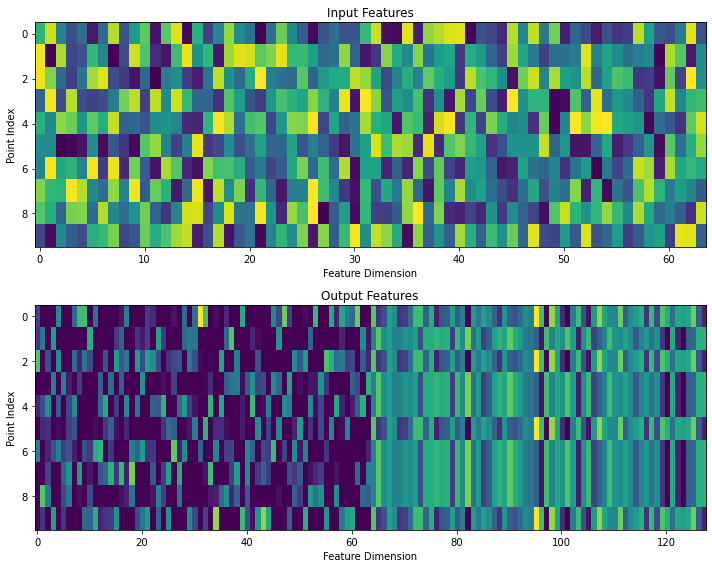

In [ ]:
#|eval: false
# Example data
inputs = torch.rand(10, 64)
unq_inv = torch.randint(0, 2, (10,))


print(f'Input shape: {inputs.shape}')
print(f'Unique inverse shape: {unq_inv.shape}')

# Initialize PFNLayer
pfn_layer = PFNLayer(in_channels=64, out_channels=128, last_layer=False)

# Forward pass
output = pfn_layer(inputs, unq_inv)

print(f'Output shape: {output.shape}')

# Plot input features and output features
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].imshow(inputs.numpy(), aspect='auto', cmap='viridis')
ax[0].set_title('Input Features')
ax[0].set_xlabel('Feature Dimension')
ax[0].set_ylabel('Point Index')

ax[1].imshow(output.detach().numpy(), aspect='auto', cmap='viridis')
ax[1].set_title('Output Features')
ax[1].set_xlabel('Feature Dimension')
ax[1].set_ylabel('Point Index')

plt.tight_layout()
plt.show()


In [ ]:
#|exports
class PillarNet(nn.Module):
    """
    PillarNet.
    The network performs dynamic pillar scatter that convert point cloud into pillar representation
    and extract pillar features

    Reference:
    PointPillars: Fast Encoders for Object Detection from Point Clouds (https://arxiv.org/abs/1812.05784)
    End-to-End Multi-View Fusion for 3D Object Detection in LiDAR Point Clouds (https://arxiv.org/abs/1910.06528)
    """

    def __init__(self,
                 num_input_features: int, # Number of input features
                 voxel_size: list, # A list that defines the size of the voxels (grids) in the x and y dimensions.
                 pc_range: list, # A list defining the range of the point cloud data in the x and y dimensions. This is used to filter and normalize the point cloud data. Only utilize x and y min
                 ):
        super().__init__()
        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

    def forward(self,
                points: torch.Tensor # Points in LiDAR coordinate, shape: (N, d), format: batch_id, x, y, z, feat1, ...
                ):

        device = points.device
        dtype = points.dtype

        # discard out of range points
        grid_size = (self.pc_range[3:] - self.pc_range[:3]
                     )/self.voxel_size  # x,  y, z
        grid_size = np.round(grid_size, 0, grid_size).astype(np.int64)

        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(points).to(device)
        pc_range = torch.from_numpy(self.pc_range).type_as(points).to(device)

        points_coords = (
            points[:, 1:4] - pc_range[:3].view(-1, 3)) / voxel_size.view(-1, 3)   # x, y, z

        mask = reduce(torch.logical_and, (points_coords[:, 0] >= 0,
                                          points_coords[:, 0] < grid_size[0],
                                          points_coords[:, 1] >= 0,
                                          points_coords[:, 1] < grid_size[1]))

        points = points[mask]
        points_coords = points_coords[mask]

        points_coords = points_coords.long()
        batch_idx = points[:, 0:1].long()

        points_index = torch.cat((batch_idx, points_coords[:, :2]), dim=1)
        unq, unq_inv = torch.unique(points_index, return_inverse=True, dim=0)
        unq = unq.int()

        points_mean_scatter = torch_scatter.scatter_mean(
            points[:, 1:4], unq_inv, dim=0)

        f_cluster = points[:, 1:4] - points_mean_scatter[unq_inv]

        # Find distance of x, y, and z from pillar center
        f_center = points[:, 1:3] - (points_coords[:, :2].to(dtype) * voxel_size[:2].unsqueeze(0) +
                                     voxel_size[:2].unsqueeze(0) / 2 + pc_range[:2].unsqueeze(0))

        # Combine together feature decorations
        features = torch.cat([points[:, 1:], f_cluster, f_center], dim=-1)

        return features, unq[:, [0, 2, 1]], unq_inv, grid_size[[1, 0]]

The `PillarNet` class is a neural network module designed for converting LiDAR point clouds into a structured pillar representation. It is based on the concepts introduced in papers such as [PointPillars: Fast Encoders for Object Detection from Point Clouds](https://arxiv.org/abs/1812.05784) and [End-to-End Multi-View Fusion for 3D Object Detection in LiDAR Point Clouds](https://arxiv.org/abs/1910.06528). This network performs a dynamic pillar scatter operation, which helps in efficiently extracting pillar features from unstructured point cloud data.

#### Core Functionality

1. **Forward Method**:
   - **Point Filtering**: The input points are filtered based on the specified `pc_range` to discard points that are outside the defined range.
   - **Grid Size Calculation**: The grid size is computed based on the `voxel_size` and `pc_range`, which determines the resolution of the voxelization.
   - **Point Coordinates Normalization**: The point coordinates are normalized with respect to the voxel size and point cloud range, converting the continuous coordinates into discrete voxel indices.
   - **Point Clustering**: The points are clustered into pillars based on their voxel indices.
   - **Feature Decoration**: Additional features are calculated, including:
     - `f_cluster`: The distance of each point from the mean of its cluster (pillar).
     - `f_center`: The distance of each point from the center of its respective voxel.
   - **Feature Aggregation**: The original point features, along with the newly computed features (`f_cluster` and `f_center`), are concatenated to form the final feature set for each point.
   - **Return Values**: The method returns the final point features, the unique pillar indices, the inverse indices used for aggregation, and the grid size.

#### Differences

1. **Abstraction of Point Cloud Operations**:
   - The `PillarNet` class abstracts the voxelization and feature extraction process, which would otherwise require manual implementation using basic PyTorch operations. It provides a higher-level interface to work with point cloud data, simplifying the process of converting point clouds into pillar-based representations.

2. **Integration of Advanced Operations**:
   - Operations like `torch_scatter.scatter_mean` are used for efficiently computing cluster mean features. These operations are not directly available in standard PyTorch and require the use of external libraries like `torch_scatter`.

3. **Grid Management**:
   - The class handles the computation of grid size and point normalization internally, which would otherwise require manual calculation and management in a more direct implementation.

#### Limitations

1. **Flexibility**:
   - While `PillarNet` provides a streamlined approach to pillar feature extraction, it may lack the flexibility needed for more customized operations or for handling point cloud data in formats that differ from the assumptions made in the class.

2. **Limited Customization**:
   - The class is designed for a specific type of pillar-based representation. Users who require different types of voxelization or feature extraction strategies may find it limiting and may need to modify or extend the class, which could be more cumbersome than implementing a direct approach from scratch.

In [ ]:
#|eval: false
# Create a sample point cloud with shape (N, d)
# Here, d includes batch_id, x, y, z, and some additional features (e.g., intensity)
points = torch.tensor([
    [0, 1.0, 2.0, 3.0, 0.5],
    [0, 2.5, 3.5, 4.5, 0.6],
    [1, 5.0, 6.0, 7.0, 0.7],
    [1, 8.0, 9.0, 10.0, 0.8]
], dtype=torch.float32)

# Define the number of input features (excluding batch_id, x, y, z)
num_input_features = points.shape[1] - 1

# Define voxel size (x_size, y_size, z_size)
voxel_size = [0.5, 0.5, 0.5]

# Define point cloud range (x_min, y_min, z_min, x_max, y_max, z_max)
pc_range = [0, 0, 0, 10, 10, 10]

# Create an instance of PillarNet
pillar_net = PillarNet(num_input_features, voxel_size, pc_range)

# Forward pass with the sample points
features, unique_voxel_indices, inverse_indices, grid_size = pillar_net(points)

# Print the results
print("Features:", features)
print("Unique Voxel Indices:", unique_voxel_indices)
print("Inverse Indices:", inverse_indices)
print("Grid Size:", grid_size)


Features: tensor([[ 1.0000,  2.0000,  3.0000,  0.5000,  0.0000,  0.0000,  0.0000, -0.2500,
         -0.2500],
        [ 2.5000,  3.5000,  4.5000,  0.6000,  0.0000,  0.0000,  0.0000, -0.2500,
         -0.2500],
        [ 5.0000,  6.0000,  7.0000,  0.7000,  0.0000,  0.0000,  0.0000, -0.2500,
         -0.2500],
        [ 8.0000,  9.0000, 10.0000,  0.8000,  0.0000,  0.0000,  0.0000, -0.2500,
         -0.2500]])
Unique Voxel Indices: tensor([[ 0,  4,  2],
        [ 0,  7,  5],
        [ 1, 12, 10],
        [ 1, 18, 16]], dtype=torch.int32)
Inverse Indices: tensor([0, 1, 2, 3])
Grid Size: [20 20]


In [ ]:
#|exports
class PillarFeatureNet(nn.Module):
    """
    Pillar Feature Net.
    The network prepares the pillar features and performs forward pass through PFNLayers. This net performs a
    similar role to SECOND's second.pytorch.voxelnet.VoxelFeatureExtractor.
    """
    def __init__(
        self,
        num_input_features: int, # Number of input features
        num_filters: list, # Number of features in each of the N PFNLayers
        voxel_size: list, # Size of voxels, only utilize x and y size
        pc_range: list, # Point cloud range, only utilize x and y min
        norm_cfg:None, # Normalization config
    ):

        super().__init__()
        assert len(num_filters) > 0
        num_input_features += 5

        # Create PillarFeatureNet layers
        num_filters = [num_input_features] + list(num_filters)
        pfn_layers = []
        for i in range(len(num_filters) - 1):
            in_filters = num_filters[i]
            out_filters = num_filters[i + 1]
            if i < len(num_filters) - 2:
                last_layer = False
            else:
                last_layer = True
            pfn_layers.append(
                PFNLayer(
                    in_filters, out_filters, norm_cfg=norm_cfg, last_layer=last_layer
                )
            )
        self.pfn_layers = nn.ModuleList(pfn_layers)

        self.feature_output_dim = num_filters[-1]

        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

        self.voxelization = PillarNet(num_input_features, voxel_size, pc_range)

    def forward(self, points):
        features, coords, unq_inv, grid_size = self.voxelization(points)
        # Forward pass through PFNLayers
        for pfn in self.pfn_layers:
            features = pfn(features, unq_inv)  # num_points, dim_feat

        feat_max = torch_scatter.scatter_max(features, unq_inv, dim=0)[0]

        return feat_max, coords, grid_size

The `PillarFeatureNet` class is designed for preparing pillar features from the point cloud data, used in 3D object detection tasks in LiDAR-based perception systems. This network handles the transformation of raw point cloud data into a more structured and feature-rich representation, which will be essential for further processing in the object detection.

#### Funcionality

1. **Initialization (`__init__` method):**
   - **Input Features Augmentation:** The class initializes by augmenting the input features with additional spatial information, increasing the dimensionality by 5 (which might include features like the relative position of points within a pillar, etc.).
   - **Layer Creation:** It then creates a sequence of layers, `PFNLayers`, which perform the feature extraction. The number of layers and their configuration are determined by the `num_filters` parameter.
   - **Voxelization:** The class initializes the voxelization process, converting the raw point cloud data into a voxel grid with specified `voxel_size` and within a specified `pc_range` (point cloud range). This voxelization is essential for handling irregular point clouds by grouping points into a regular grid structure, called "pillars."

2. **Forward Pass (`forward` method):**
   - **Voxelization:** The input point cloud is first voxelized, where the points are grouped into pillars, and features are extracted.
   - **PFN Layers:** The extracted features are passed through the `PFNLayers`, where each layer performs a certain amount of processing. These layers typically involve operations like PointNet-style feature learning.
   - **Max Pooling:** Finally, the features are aggregated using a max-pooling operation (`torch_scatter.scatter_max`), which pools the features across the points in each pillar to get a fixed-size feature vector for each pillar.

#### Abstraction
This class abstracts several operations that would require more manual implementation in pure PyTorch. For instance, voxelization and the subsequent grouping of points into pillars are handled internally by the `PillarNet` class.

The abstraction can reduce flexibility. If you need to tweak certain aspects of the feature extraction or voxelization process, this might be harder to do compared to a more manual approach where every operation is explicit.

In [ ]:
#|eval: false
# Define input parameters for PillarFeatureNet
# Mock values for demonstration purposes
num_input_features = 3
num_filters = [64, 128]
voxel_size = [0.2, 0.2, 0.2]
pc_range = [0, 0, 0, 50, 50, 50]
norm_cfg = None

# Instantiate the PillarFeatureNet
pillar_feature_net = PillarFeatureNet(
    num_input_features=num_input_features,
    num_filters=num_filters,
    voxel_size=voxel_size,
    pc_range=pc_range,
    norm_cfg=norm_cfg
)

# Create some dummy input points
# Each point might have x, y, z, intensity, etc.
num_points = 100  # Number of points in the point cloud
points = torch.rand(num_points, num_input_features + 1)  # Random points (x, y, z, intensity)

# Run a forward pass
feat_max, coords, grid_size = pillar_feature_net(points)

# Print the outputs
print("Max Features:\n", feat_max)
print("Voxel Coordinates:\n", coords)
print("Grid Size:\n", grid_size)

Max Features:
 tensor([[0.0000, 1.9903, 1.5468,  ..., 0.1351, 1.5962, 1.8613],
        [0.0953, 0.8951, 0.5835,  ..., 0.3777, 0.4148, 1.1723],
        [0.0000, 0.0000, 0.0628,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.6913, 0.4461,  ..., 1.3929, 0.0906, 1.3596],
        [0.0000, 0.0000, 0.0000,  ..., 0.1496, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 1.5835, 0.0000, 0.0030]],
       grad_fn=<CppNode<ScatterMax>>)
Voxel Coordinates:
 tensor([[0, 0, 0],
        [0, 1, 0],
        [0, 2, 0],
        [0, 3, 0],
        [0, 4, 0],
        [0, 0, 1],
        [0, 1, 1],
        [0, 2, 1],
        [0, 3, 1],
        [0, 4, 1],
        [0, 0, 2],
        [0, 1, 2],
        [0, 2, 2],
        [0, 3, 2],
        [0, 4, 2],
        [0, 0, 3],
        [0, 1, 3],
        [0, 2, 3],
        [0, 3, 3],
        [0, 4, 3],
        [0, 0, 4],
        [0, 1, 4],
        [0, 2, 4],
        [0, 3, 4],
        [0, 4, 4]], dtype=torch.int32)
Grid Size:
 [250 250]


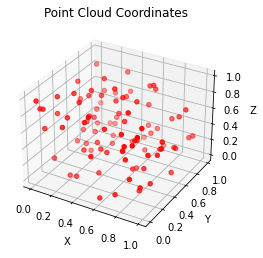

In [ ]:
#|eval: false
# Create some dummy input points
num_points = 100  # Number of points in the point cloud
points = torch.rand(num_points, num_input_features + 1)  # Random points (x, y, z, intensity)

# Visualize the input using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot point cloud coordinates
ax.scatter(points[:, 0].numpy(), points[:, 1].numpy(), points[:, 2].numpy(), c='r', marker='o')

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Title
ax.set_title('Point Cloud Coordinates')

plt.show()

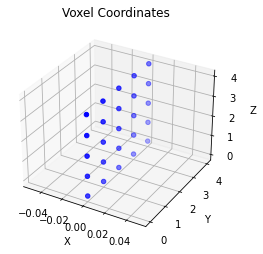

In [ ]:
#|eval: false
# Visualize the output using matplotlib
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot voxel coordinates
ax.scatter(coords[:, 0].numpy(), coords[:, 1].numpy(), coords[:, 2].numpy(), c='b', marker='o')

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Title
ax.set_title('Voxel Coordinates')

plt.show()

## Voxel Encoder

In [ ]:
#|exports
class DynamicVoxelEncoder(nn.Module):
    """
    Dynamic version of VoxelFeatureExtractorV3
    """

    def __init__(self):
        super(DynamicVoxelEncoder, self).__init__()

    def forward(self, inputs, unq_inv):
        features = torch_scatter.scatter_mean(inputs, unq_inv, dim=0)

        return features

In [ ]:
#|exports
class VoxelNet(nn.Module):
    """
    Dynamic voxelization for point clouds

    This class performs dynamic voxelization on input point clouds.
    It converts point coordinates into voxel grid coordinates and removes points that fall outside the specified range.
    """

    def __init__(self,
                voxel_size, # size of voxel
                pc_range # point cloud range
                ):
        super().__init__()
        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

    def forward(self, points):
        """
        points: Tensor: (N, d), batch_id, x, y, z, ...
        """
        device = points.device

        # voxel range of x, y, z
        grid_size = (self.pc_range[3:] - self.pc_range[:3]) / self.voxel_size
        grid_size = np.round(grid_size, 0, grid_size).astype(np.int64)

        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(points).to(device)
        pc_range = torch.from_numpy(self.pc_range).type_as(points).to(device)

        points_coords = (
            points[:, 1:4] - pc_range[:3].view(-1, 3)) / voxel_size.view(-1, 3)  # x, y, z

        mask = reduce(torch.logical_and, (points_coords[:, 0] >= 0,
                                          points_coords[:, 0] < grid_size[0],
                                          points_coords[:, 1] >= 0,
                                          points_coords[:, 1] < grid_size[1],
                                          points_coords[:, 2] >= 0,
                                          points_coords[:, 2] < grid_size[2]))  # remove the points out of range

        points = points[mask]
        points_coords = points_coords[mask]

        points_coords = points_coords.long()
        batch_idx = points[:, 0:1].long()
        point_index = torch.cat((batch_idx, points_coords), dim=1)

        unq, unq_inv = torch.unique(point_index, return_inverse=True, dim=0)
        unq = unq.int()

        features = points[:, 1:]

        return features, unq[:, [0, 3, 2, 1]], unq_inv, grid_size[[2, 1, 0]]

Input Points:
tensor([[0.0000, 5.1454, 2.3374, 9.9073],
        [0.0000, 8.4996, 3.2674, 0.0379],
        [0.0000, 0.7200, 9.5793, 4.5018],
        [0.0000, 2.4532, 3.3480, 0.9841],
        [0.0000, 5.1391, 0.7281, 4.1405],
        [0.0000, 9.7150, 0.4090, 0.0740],
        [0.0000, 8.9659, 8.5211, 5.7163],
        [0.0000, 4.9131, 7.7118, 0.5395],
        [0.0000, 5.2191, 0.7674, 2.3421],
        [0.0000, 2.7364, 1.3320, 4.8849]])

Features:
tensor([[5.1454, 2.3374, 9.9073],
        [8.4996, 3.2674, 0.0379],
        [0.7200, 9.5793, 4.5018],
        [2.4532, 3.3480, 0.9841],
        [5.1391, 0.7281, 4.1405],
        [9.7150, 0.4090, 0.0740],
        [8.9659, 8.5211, 5.7163],
        [4.9131, 7.7118, 0.5395],
        [5.2191, 0.7674, 2.3421],
        [2.7364, 1.3320, 4.8849]])

Voxel Coordinates:
tensor([[ 0,  9, 19,  1],
        [ 0,  1,  6,  4],
        [ 0,  9,  2,  5],
        [ 0,  1, 15,  9],
        [ 0,  4,  1, 10],
        [ 0,  8,  1, 10],
        [ 0, 19,  4, 10],
        [ 0

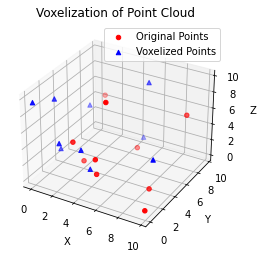

In [ ]:
#|eval: false
# Create an instance of VoxelNet
voxel_size = [0.5, 0.5, 0.5]
pc_range = [0, 0, 0, 10, 10, 10]
voxel_net = VoxelNet(voxel_size, pc_range)

# Generate synthetic point cloud data
batch_size = 1
num_points = 10
points = torch.cat((
    torch.zeros(num_points, 1),  # batch_id
    torch.rand(num_points, 3) * 10  # x, y, z
), dim=1)

# Forward pass
features, voxel_coords, unq_inv, grid_size = voxel_net(points)

# Print input and output
print("Input Points:")
print(points)
print("\nFeatures:")
print(features)
print("\nVoxel Coordinates:")
print(voxel_coords)
print("\nUnique Inverse Indices:")
print(unq_inv)
print("\nGrid Size:")
print(grid_size)

# Visual demonstration using matplotlib
# Plot original and voxelized points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 1], points[:, 2], points[:, 3], c='r', marker='o', label='Original Points')

# Convert voxel coordinates to real world coordinates
voxel_size = np.array([0.5, 0.5, 0.5])
pc_range_min = np.array([0, 0, 0])
real_coords = voxel_coords[:, 1:4].numpy() * voxel_size + pc_range_min

ax.scatter(real_coords[:, 0], real_coords[:, 1], real_coords[:, 2], c='b', marker='^', label='Voxelized Points')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend()
plt.title('Voxelization of Point Cloud')
plt.show()

In [ ]:
#|exports
class VoxelFeatureNet(nn.Module):
    """
    This class performs dynamic voxelization of point clouds and then encodes the voxel features using DynamicVoxelEncoder.
    """
    def __init__(self,
                voxel_size, # size of voxel
                pc_range # point cloud range
                ):
        super().__init__()

        self.voxelization = VoxelNet(voxel_size, pc_range)
        self.voxel_encoder = DynamicVoxelEncoder()

    def forward(self, points):
        features, coords, unq_inv, grid_size = self.voxelization(points)

        features = self.voxel_encoder(features, unq_inv)

        return features, coords, grid_size

In [ ]:
#|eval: false
# Create an instance of VoxelFeatureNet
voxel_size = [0.1, 0.1, 0.1]
pc_range = [0, -40, -3, 70.4, 40, 1]

voxel_feature_net = VoxelFeatureNet(voxel_size, pc_range)

# Generate synthetic point cloud data
# Format: [batch_id, x, y, z, ...]
batch_size = 2
num_points = 500
num_features = 4  # x, y, z, intensity

points = torch.cat([
    torch.randint(0, batch_size, (num_points, 1)).float(),  # batch_id
    torch.rand(num_points, 3) * torch.tensor([70.4, 80, 4]) - torch.tensor([0, 40, 3]),  # x, y, z
    torch.rand(num_points, num_features - 3)  # additional features
], dim=1)

# Forward pass through the VoxelFeatureNet
features, coords, grid_size = voxel_feature_net(points)

In [ ]:
#|eval: false
#|hide
# Print the results
print("Input Points:")
print(points)
print("\nVoxel Features:")
print(features)
print("\nVoxel Coordinates:")
print(coords)
print("\nGrid Size:")
print(grid_size)

Input Points:
tensor([[ 1.0000e+00,  5.4810e+01, -3.0723e+01, -1.1675e+00,  8.6586e-01],
        [ 1.0000e+00,  1.4629e+01, -3.7614e+01,  1.6025e-01,  6.2176e-03],
        [ 1.0000e+00,  1.8246e+00,  3.7470e+01,  8.6680e-01,  7.0484e-01],
        ...,
        [ 0.0000e+00,  6.8477e+01, -1.8193e+01, -9.5289e-01,  8.6558e-01],
        [ 0.0000e+00,  1.7670e+01,  3.2634e+01, -1.7098e-01,  2.8662e-01],
        [ 1.0000e+00,  6.2493e+01, -1.4022e+01, -2.6558e+00,  7.1003e-01]])

Voxel Features:
tensor([[  0.1477,  29.8719,  -1.2833,   0.2570],
        [  0.2316,   2.8208,  -2.3478,   0.7143],
        [  0.5099,  -2.9513,   0.4068,   0.4859],
        ...,
        [ 69.7025, -16.1682,  -1.5687,   0.3905],
        [ 70.3757, -19.8596,   0.8273,   0.9861],
        [ 70.3201,   8.9887,  -1.2092,   0.4476]])

Voxel Coordinates:
tensor([[  0,  17, 698,   1],
        [  0,   6, 428,   2],
        [  0,  34, 370,   5],
        ...,
        [  1,  14, 238, 697],
        [  1,  38, 201, 703],
        

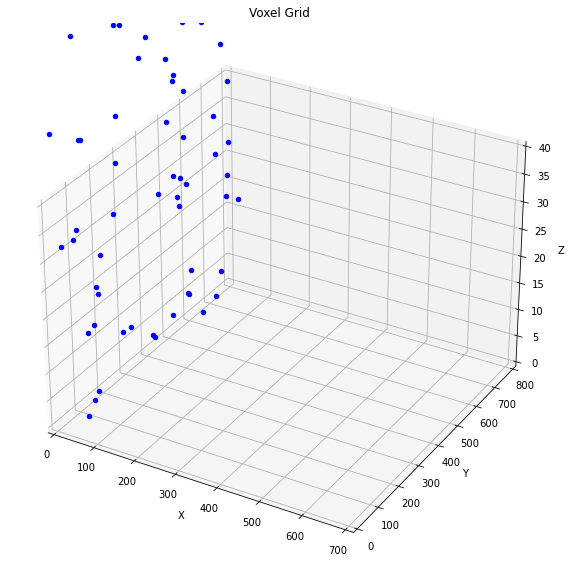

In [ ]:
#|eval: false
# Visual demonstration using matplotlib
def plot_voxel_grid(coords, grid_size):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the voxel grid
    ax.set_xlim(0, grid_size[2])
    ax.set_ylim(0, grid_size[1])
    ax.set_zlim(0, grid_size[0])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # Plot the occupied voxels
    for coord in coords:
        ax.scatter(coord[1], coord[2], coord[3], c='b', marker='o')

    plt.title('Voxel Grid')
    plt.show()

# Plot the voxel grid with occupied coordinates
plot_voxel_grid(coords, grid_size)

## MVF Enconder

In [ ]:
#|exports
class PointNet(nn.Module):
    """
    Linear Process for point feature
    """

    def __init__(self,
                in_channels:int, # Number of input channels
                out_channels:int # Number of output channels
                ):
        super().__init__()
        self.linear = nn.Linear(in_channels, out_channels, bias=False)
        self.norm = nn.BatchNorm1d(out_channels, eps=1e-3, momentum=0.01)

    def forward(self, points):
        torch.backends.cudnn.enabled = False
        x = self.linear(points)
        x = self.norm(x)
        x = F.relu(x)
        torch.backends.cudnn.enabled = True

        return x

In [ ]:
#|exports
class PillarVoxelNet(nn.Module):
    """
    This class implements the voxelization process, converting point clouds into voxel grid indices and computing features for each point relative to the voxel grid.
    """
    def __init__(self,
                voxel_size, # Size of voxels, only utilize x and y size
                pc_range # Point cloud range, only utilize x and y min
                ):
        super().__init__()
        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

    def forward(self, points):
        device = points.device
        dtype = points.dtype

        grid_size = (self.pc_range[3:] - self.pc_range[:3]
                     )/self.voxel_size  # x,  y, z
        grid_size = np.round(grid_size, 0, grid_size).astype(np.int64)

        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(points).to(device)
        pc_range = torch.from_numpy(self.pc_range).type_as(points).to(device)

        points_coords = (
            points[:, 1:4] - pc_range[:3].view(-1, 3)) / voxel_size.view(-1, 3)   # x, y, z
        points_coords[:, 0] = torch.clamp(
            points_coords[:, 0], 0, grid_size[0] - 1)
        points_coords[:, 1] = torch.clamp(
            points_coords[:, 1], 0, grid_size[1] - 1)
        points_coords[:, 2] = torch.clamp(
            points_coords[:, 2], 0, grid_size[2] - 1)

        points_coords = points_coords.long()
        batch_idx = points[:, 0:1].long()

        points_index = torch.cat((batch_idx, points_coords[:, :2]), dim=1)
        unq, unq_inv = torch.unique(points_index, return_inverse=True, dim=0)
        unq = unq.int()        # breakpoint()

        points_mean_scatter = torch_scatter.scatter_mean(
            points[:, 1:4], unq_inv, dim=0)

        f_cluster = points[:, 1:4] - points_mean_scatter[unq_inv]

        # Find distance of x, y, and z from pillar center
        f_center = points[:, 1:3] - (points_coords[:, :2].to(dtype) * voxel_size[:2].unsqueeze(0) +
                                     voxel_size[:2].unsqueeze(0) / 2 + pc_range[:2].unsqueeze(0))

        # Combine together feature decorations
        features = torch.cat([points[:, 1:], f_cluster, f_center], dim=-1)

        return features, unq[:, [0, 2, 1]], unq_inv, grid_size[[1, 0]]

In [ ]:
#|eval:false
# Create an instance of PillarVoxelNet
voxel_size = [0.2, 0.2, 4]
pc_range = [0, 0, -3, 70.4, 40, 1]
pillar_voxel_net = PillarVoxelNet(voxel_size, pc_range)

# Generate synthetic point cloud data
batch_size = 1
num_points = 10
points = torch.rand(num_points, 4)
points[:, 0] = 0  # All points belong to the same batch
points[:, 1] = points[:, 1] * (pc_range[3] - pc_range[0]) + pc_range[0]
points[:, 2] = points[:, 2] * (pc_range[4] - pc_range[1]) + pc_range[1]
points[:, 3] = points[:, 3] * (pc_range[5] - pc_range[2]) + pc_range[2]

# Forward pass
features, unq, unq_inv, grid_size = pillar_voxel_net(points)

# Print the results
print("Features:")
print(features)
print("\nUnique Pillar Indices (Batch, X, Y):")
print(unq)
print("\nGrid Size (Y, X):")
print(grid_size)

Features:
tensor([[ 2.3704e+01,  2.8256e+01, -1.9798e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  3.5553e-03, -4.4041e-02],
        [ 1.0087e+01,  6.1095e+00, -3.1646e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.3090e-02,  9.5429e-03],
        [ 5.4948e+01,  1.8746e+01, -2.3587e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  4.7882e-02,  4.5704e-02],
        [ 5.5123e+01,  1.7003e+01, -2.0925e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  2.3098e-02, -9.7160e-02],
        [ 5.7509e+01,  1.8222e+01, -2.2636e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  9.4337e-03, -7.7551e-02],
        [ 4.1481e+01,  2.1276e+01, -6.7486e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00, -1.9176e-02, -2.3525e-02],
        [ 9.8798e-01,  3.4320e+01,  1.4192e-01,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  8.7983e-02,  1.9520e-02],
        [ 5.6135e+01,  2.2593e+01, -1.4039e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  3.4702e-02,  9.2648e-02],
      

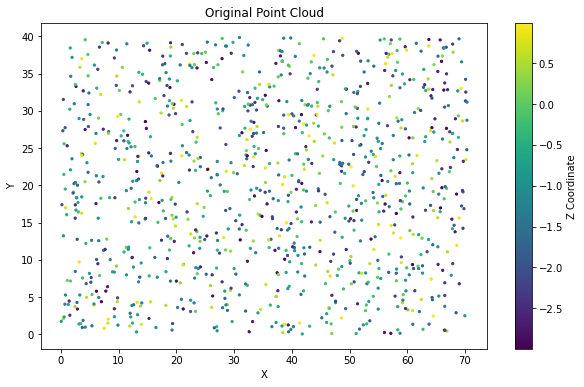

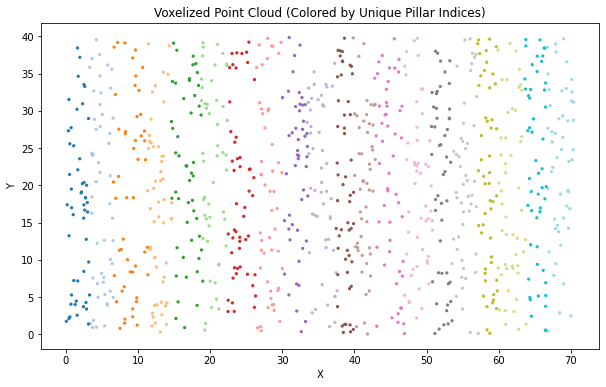

In [ ]:
#|eval:false
# Create an instance of PillarVoxelNet
voxel_size = [0.2, 0.2, 4]
pc_range = [0, 0, -3, 70.4, 40, 1]
pillar_voxel_net = PillarVoxelNet(voxel_size, pc_range)

# Generate synthetic point cloud data
batch_size = 1
num_points = 1000
points = torch.rand(num_points, 4)
points[:, 0] = 0  # All points belong to the same batch
points[:, 1] = points[:, 1] * (pc_range[3] - pc_range[0]) + pc_range[0]
points[:, 2] = points[:, 2] * (pc_range[4] - pc_range[1]) + pc_range[1]
points[:, 3] = points[:, 3] * (pc_range[5] - pc_range[2]) + pc_range[2]

# Forward pass
features, unq, unq_inv, grid_size = pillar_voxel_net(points)

# # Plot original point cloud
plt.figure(figsize=(10, 6))
plt.scatter(points[:, 1], points[:, 2], c=points[:, 3], cmap='viridis', s=5)
plt.colorbar(label='Z Coordinate')
plt.title('Original Point Cloud')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Plot voxelized point cloud (colored by unique pillar indices)
unique_pillar_colors = plt.cm.get_cmap('tab20', len(unq))
color_map = unique_pillar_colors(unq_inv.numpy() % len(unq))
plt.figure(figsize=(10, 6))
plt.scatter(points[:, 1], points[:, 2], c=color_map, s=5)
plt.title('Voxelized Point Cloud (Colored by Unique Pillar Indices)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [ ]:
#|exports
class CylinderNet(nn.Module):
    def __init__(self,
                voxel_size, # Size of voxels, only utilize x and y size
                pc_range # Point cloud range, only utilize x and y min
                ):
        super().__init__()
        self.voxel_size = np.array(voxel_size)
        self.pc_range = np.array(pc_range)

    def forward(self, points):
        device = points.device
        dtype = points.dtype
        points_x = points[:, 1:2]
        points_y = points[:, 2:3]
        points_z = points[:, 3:4]
        points_phi = torch.atan2(points_y, points_x) / np.pi * 180
        points_rho = torch.sqrt(points_x ** 2 + points_y ** 2)
        points_cylinder = torch.cat(
            (points[:, 0:1], points_phi, points_z, points_rho, points[:, 4:]), dim=-1)

        grid_size = (self.pc_range[3:] - self.pc_range[:3]
                     )/self.voxel_size  # phi, z, rho
        grid_size = np.round(grid_size, 0, grid_size).astype(np.int64)

        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(points).to(device)
        pc_range = torch.from_numpy(self.pc_range).type_as(points).to(device)

        points_coords = (
            points_cylinder[:, 1:4] - pc_range[:3].view(-1, 3)) / voxel_size.view(-1, 3)
        points_coords[:, 0] = torch.clamp(
            points_coords[:, 0], 0, grid_size[0] - 1)
        points_coords[:, 1] = torch.clamp(
            points_coords[:, 1], 0, grid_size[1] - 1)
        points_coords[:, 2] = torch.clamp(
            points_coords[:, 2], 0, grid_size[2] - 1)
        points_coords = points_coords.long()
        batch_idx = points_cylinder[:, 0:1].long()

        points_index = torch.cat((batch_idx, points_coords[:, :2]), dim=1)
        unq, unq_inv = torch.unique(points_index, return_inverse=True, dim=0)
        unq = unq.int()

        points_mean_scatter = torch_scatter.scatter_mean(
            points_cylinder[:, 1:4], unq_inv, dim=0)
        f_cluster = points_cylinder[:, 1:4] - points_mean_scatter[unq_inv]

        # Find distance of x, y, and z from pillar center
        f_center = points_cylinder[:, 1:3] - (points_coords[:, :2].to(dtype) * voxel_size[:2].unsqueeze(0) +
                                              voxel_size[:2].unsqueeze(0) / 2 + pc_range[:2].unsqueeze(0))

        # Combine together feature decorations
        features = torch.cat(
            [points_cylinder[:, 1:], f_cluster, f_center], dim=-1)

        return features, unq[:, [0, 2, 1]], unq_inv, grid_size[[1, 0]]

In [ ]:
#|exports
class SingleView(nn.Module):
    """
    authoured by Beijing-jinyu
    convolution for single view
    """

    def __init__(self,
                 in_channels,  # Number of input channels
                 num_filters,  # Number of features in each of the N PFNLayers
                 layer_nums,  # Number of blocks in each layer
                 ds_layer_strides,  # Strides of each layer
                 ds_num_filters,  # Number of features in each layer
                 kernel_size,  # Kernel size of each layer
                 mode,  # Mode of the network
                 voxel_size,  # Size of voxels, only utilize x and y size
                 pc_range,  # Point cloud range, only utilize x and y min
                 norm_cfg=None,  # Normalization config
                 act_cfg=None,  # Activation config
                 ):
        super().__init__()
        self.mode = mode
        self.voxel_size = np.array(voxel_size[:2])
        self.bias = np.array(pc_range[:2])
        num_filters = [in_channels] + list(num_filters)
        pfn_layers = []
        for i in range(len(num_filters) - 1):
            in_filters = num_filters[i]
            out_filters = num_filters[i + 1]
            if i < len(num_filters) - 2:
                last_layer = False
            else:
                last_layer = True
            pfn_layers.append(
                PFNLayer(
                    in_filters, out_filters, norm_cfg=norm_cfg, last_layer=last_layer
                )
            )
        in_filters = [num_filters[-1], *ds_num_filters[:-1]]
        self.pfn_layers = nn.ModuleList(pfn_layers)
        blocks = []
        for i, layer_num in enumerate(layer_nums):
            block = self._make_layer(
                in_filters[i],
                ds_num_filters[i],
                kernel_size[i],
                ds_layer_strides[i],
                layer_num)
            blocks.append(block)

        self.blocks = nn.ModuleList(blocks)
        self.ds_rate = np.prod(np.array(ds_layer_strides))

    def _make_layer(self, inplanes, planes, kernel_size, stride, num_blocks):

        layers = []
        layers.append(SparseConvBlock(inplanes, planes,
                      kernel_size=kernel_size, stride=stride, use_subm=False))

        for j in range(num_blocks):
            layers.append(SparseBasicBlock(planes, kernel_size=kernel_size))

        return spconv.pytorch.SparseSequential(*layers)

    def forward(self, features, unq, unq_inv, grid_size):
        feature_pos = features[:,
                               0:2] if self.mode == 'pillar' else features[:, 10:12]
        device = feature_pos.device
        voxel_size = torch.from_numpy(
            self.voxel_size).type_as(feature_pos).to(device)
        bias = torch.from_numpy(self.bias).type_as(feature_pos).to(device)
        feature_pos = (feature_pos - bias) / voxel_size

        for pfn in self.pfn_layers:
            features = pfn(features, unq_inv)  # num_points, dim_feat
        features_voxel = torch_scatter.scatter_max(features, unq_inv, dim=0)[0]
        batch_size = len(torch.unique(unq[:, 0]))
        x = spconv.pytorch.SparseConvTensor(
            features_voxel, unq, grid_size, batch_size)

        for i in range(len(self.blocks)):
            x = self.blocks[i](x)
        x = x.dense()
        feature_pos = torch.cat(
            (unq[unq_inv][:, 0:1], feature_pos / self.ds_rate), dim=-1)

        return self.bilinear_interpolate(x, feature_pos)

    def bilinear_interpolate(self, image, coords):
        """
        image: (B, C, H, W)
        coords: (N, 3): (B, y, x)
        """
        x = coords[:, 1]
        x0 = torch.floor(x).long()
        x1 = x0 + 1

        y = coords[:, 2]
        y0 = torch.floor(y).long()
        y1 = y0 + 1

        B = coords[:, 0].long()

        x0 = torch.clamp(x0, 0, image.shape[3] - 1)
        x1 = torch.clamp(x1, 0, image.shape[3] - 1)
        y0 = torch.clamp(y0, 0, image.shape[2] - 1)
        y1 = torch.clamp(y1, 0, image.shape[2] - 1)

        Ia = image[B, :, y0, x0]
        Ib = image[B, :, y1, x0]
        Ic = image[B, :, y0, x1]
        Id = image[B, :, y1, x1]

        wa = ((x1.type(torch.float32)-x) *
              (y1.type(torch.float32)-y)).unsqueeze(-1)
        wb = ((x1.type(torch.float32)-x) *
              (y-y0.type(torch.float32))).unsqueeze(-1)
        wc = ((x-x0.type(torch.float32)) *
              (y1.type(torch.float32)-y)).unsqueeze(-1)
        wd = ((x-x0.type(torch.float32)) *
              (y-y0.type(torch.float32))).unsqueeze(-1)

        features = Ia * wa + Ib * wb + Ic * wc + Id * wd

        return features

* The `forward` method of `single_view` is called with `features`, `unq`, `unq_inv`, and `grid_size` as inputs. This method processes the features through PFNLayers, voxelizes them, and applies several sparse convolution blocks.
* The `bilinear_interpolate` method is used within the forward method to interpolate the features based on the coordinates.

In [ ]:
#|eval: false
# Instantiate the SingleView model
in_channels = 64
num_filters = [128, 256]
layer_nums = [2, 2]
ds_layer_strides = [2, 2]
ds_num_filters = [256, 512]
kernel_size = [3, 3]
mode = 'pillar'
voxel_size = [0.2, 0.2]
pc_range = [-50, -50]
norm_cfg = None
act_cfg = None

model = SingleView(in_channels, num_filters, layer_nums, ds_layer_strides, ds_num_filters, kernel_size, mode, voxel_size, pc_range, norm_cfg, act_cfg).to(DEVICE)

# Create dummy data and transfer to the same device
features = torch.randn(1000, 64, dtype=torch.float32).to(DEVICE)
unq = torch.randint(0, 10, (1000, 3), dtype=torch.int32).to(DEVICE)
unq_inv = torch.randint(0, 1000, (1000,), dtype=torch.int64).to(DEVICE)
grid_size = [200, 200]  # 2D spatial shape

# Input shapes
print("Features Shape:", features.shape)

# Forward pass
output_features = model(features, unq, unq_inv, grid_size)

print("Output Features Shape:", output_features.shape)

Features Shape: torch.Size([1000, 64])
Output Features Shape: torch.Size([1000, 512])


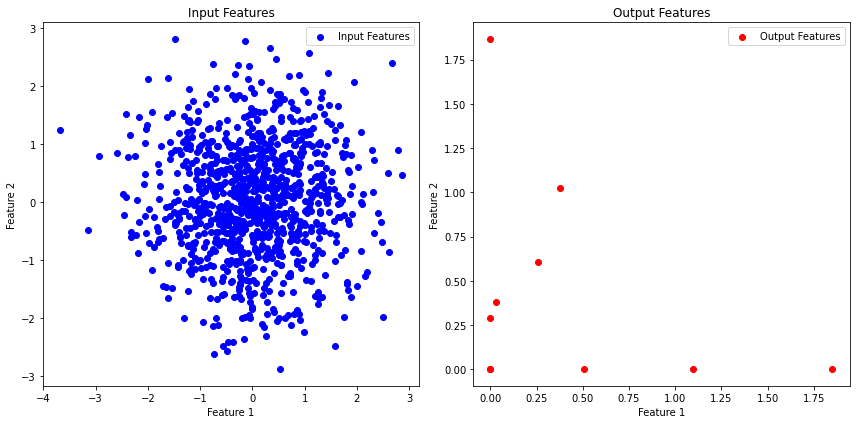

In [ ]:
#|eval: false
# Visualize input features (first two dimensions) before processing
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(features[:, 0].cpu().numpy(), features[:, 1].cpu().numpy(), c='blue', label='Input Features')
plt.title('Input Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

# Detach the output tensor from the computation graph
output = output.detach()

# Visualize output features (first two dimensions) after processing
plt.subplot(1, 2, 2)
plt.scatter(output[:, 0].cpu().numpy(), output[:, 1].cpu().numpy(), c='red', label='Output Features')
plt.title('Output Features')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#|exports
class MVFFeatureNet(nn.Module):
    """
    authoured by Beijing-jinyu
    """

    def __init__(self,
                in_channels, # Number of input channels
                voxel_size, # Size of voxels, only utilize x and y size
                pc_range, # Point cloud range, only utilize x and y min
                cylinder_size, # Size of cylinders, only utilize x and y size
                cylinder_range, # Cylinder range, only utilize x and y min
                num_filters, # Number of features in each of the N PFNLayers
                layer_nums, # Number of blocks in each layer
                ds_layer_strides, # Strides of each layer
                ds_num_filters, # Number of features in each layer
                kernel_size, # Kernel size of each layer
                out_channels # Number of output channels
                ):
        super().__init__()
        self.in_channels = in_channels
        self.voxel_size = voxel_size
        self.pc_range = pc_range
        self.cylinder_range = cylinder_range
        self.cylinder_size = cylinder_size

        self.voxelization = PillarVoxelNet(voxel_size, pc_range)
        self.cylinderlization = CylinderNet(cylinder_size, cylinder_range)

        self.pillarview = SingleView((in_channels + 5) * 2, num_filters, layer_nums, ds_layer_strides,
                                     ds_num_filters, kernel_size, 'pillar', self.voxel_size, self.pc_range)
        self.cylinderview = SingleView((in_channels + 5) * 2, num_filters, layer_nums, ds_layer_strides,
                                       ds_num_filters, kernel_size, 'cylinder', self.cylinder_size, self.cylinder_range)
        self.ds_rate = np.prod(np.array(ds_layer_strides))

        self.pointnet1 = PointNet((in_channels + 5) * 2, ds_num_filters[-1])
        self.pointnet2 = PointNet(ds_num_filters[-1] * 3, out_channels)

    def forward(self, points):
        dtype = points.dtype
        pc_range = torch.tensor(self.pc_range, dtype=dtype)
        mask = reduce(torch.logical_and, (points[:, 1] >= pc_range[0],
                                          points[:, 1] < pc_range[3],
                                          points[:, 2] >= pc_range[1],
                                          points[:, 2] < pc_range[4],
                                          points[:, 3] >= pc_range[2],
                                          points[:, 3] < pc_range[5]))
        points = points[mask]

        pillar_feature, pillar_coords, pillar_inv, pillar_size = self.voxelization(
            points)
        cylinder_feature, cylinder_coords, cylinder_inv, cylinder_size = self.cylinderlization(
            points)
        points_feature = torch.cat((pillar_feature, cylinder_feature), dim=-1)

        pillar_view = self.pillarview(
            points_feature, pillar_coords, pillar_inv, pillar_size)
        cylinder_view = self.cylinderview(
            points_feature, cylinder_coords, cylinder_inv, cylinder_size)

        points_feature = self.pointnet1(points_feature)
        points_feature = torch.cat(
            (points_feature, pillar_view, cylinder_view), dim=-1)
        pillar_feature = self.pointnet2(points_feature)
        pillar_feature = torch_scatter.scatter_max(
            pillar_feature, pillar_inv, dim=0)[0]
        batch_size = len(torch.unique(pillar_coords[:, 0]))
        pillar_coords[:, 1:] = pillar_coords[:, 1:] // self.ds_rate
        pillar_size = pillar_size // self.ds_rate
        x = spconv.pytorch.SparseConvTensor(
            pillar_feature, pillar_coords, pillar_size, batch_size)
        return x.dense()